
# Project Milestone One: Forming Your Team, Understanding the Problem, and Exploring the Data

#### **Due:** Midnight on October 26th (with 2-hour grace period) — **worth 20 points**

> **Note:** Because we must begin manual grading immediately, there will be *no* late period for this milestone. 

This milestone is the first phase of your project. You’ll begin working in teams, select your dataset, perform basic exploratory data analysis (EDA), and frame your classification problem.  

1. **Form your project team.**  
   Convene your team and complete the **Team Contract** (available in your Homework Repository). This is **due on Sunday, October 19th** at midnight (along with Homework 07). Each member must review and sign it before submission.

2. **Select a team leader.**  
   Choose one team member to act as the **Gradescope submitter** for your team. The entire team should collaborate on the notebook, but only the leader will submit.

3. **Explore your dataset and frame your task.**  
   You’ll work through the notebook to  
   - Examine both provided datasets,  
   - Choose one for your project,  
   - Conduct basic EDA to understand its structure and challenges, and  
   - Define the classification problem you’ll be solving in business or applied terms.  

This milestone focuses on understanding your data and clearly articulating what your model will eventually predict. You are not required to a model yet (that will happen in Milestone 2) but of course you have lots of example models to choose from previous Homeworks and Coding Notebooks and you may wish to explore a baseline model as you do this first phase of your project. 


### The Datasets

The final project is a **classification task** using **one of two datasets**—one image-based and one text-based. These are the two
domains we have studied in detail, after learning the fundamentals in the first three weeks, and you have all you need to approach either of these datasets with confidence. 

#### **1. Food-101 (Images)**  
A web-scraped collection of approximately **101,000 color photos** across **101 food categories** (≈ 800 train / 100 validation / 100 test per class).  
Images vary widely in **lighting, composition, and color balance**, making this dataset excellent for practicing **data cleaning**, **EDA**, and **augmentation** techniques such as random crops, flips, and color jitter. 

#### **2. HuffPost News Category (Text)**  
Roughly **200,000 short news items** labeled into **41 topical categories** (e.g., *POLITICS*, *ENTERTAINMENT*, *PARENTING*).  
Each record contains a **headline**, a **short description**, and a **combined text field** in the form  
> `"headline [SEP] short_description"`.
> 
The `[SEP]` token simply marks where the headline ends and the description begins—mirroring conventions used in transformer models such as BERT.


### What To Do

After reviewing both datasets, you’ll **choose one** to use for your semester project.  
In the following sections of the notebook, you'll do the following. Some of this is already done in the template code given below for each of the two datasets.  

- **Download** your selected dataset.  
- **Perform exploratory data analysis (EDA)** to understand its scale, structure, and class balance. 
- **Visualize** representative samples (images or text excerpts).  
- **Identify potential challenges,** such as overlapping categories, imbalanced labels, or data-quality issues.  
- **Create an 80/10/10 train–validation–test split** to use consistently throughout Milestones 1 and 2 and your final report.  

> **Important:** Keep only the section for the dataset you select, and delete the other before submitting your notebook for Milestone 1.


In [1]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel
from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


## Step One: Choose your dataset and take a look

You’ll pick **one** dataset—either **Food-101 (images)** or **HuffPost (text)**—and run the starter cells to confirm it loads, view class stats, and skim a few samples.

* **Food-101 (images):** 101 classes of web photos with **inconsistent lighting, white balance, color casts, and composition** (plus varying resolutions). These natural quirks make augmentation and input-pipeline choices meaningful.
* **HuffPost (text):** ~200k headline/summary pairs across 41 topics with **class imbalance** and some **category overlap**—good for trying stratified splits and reporting macro-F1 in addition to accuracy.

After you review the two sections below (download → minimal EDA → split), **keep one and delete the other.** Stick with your choice for the entire project.

> **Note:** We use Hugging Face **Dataset/DatasetDict** objects (table-like datasets), not NumPy/Pandas arrays. Most of what you need to know is contained in the template code, but see the **Appendix** for more information on HG Datasets. 


In [2]:
# If needed (in a new env):
# !pip install -U datasets matplotlib pillow

---

### Dataset One (Images): Food-101

#### **Load Food-101 as a Dataset**

> Note: this loads a **Hugging Face `Dataset`**, not NumPy or TensorFlow tensors.
> Each sample is stored as a **dictionary** with two keys — `"image"` (a PIL image object) and `"label"` (an integer class ID).
> You can access columns by name, e.g. `food_all["image"]` or `food_all["label"]`, and check the dataset size with `len(food_all)`.
> Unlike arrays, image sizes and aspect ratios may differ across samples — you’ll handle resizing or normalization later during preprocessing.


In [3]:
food_all = load_dataset("food101", split="train+validation")  # ~101k images total
label_col = "label"

# Sanity check the label column
assert label_col in food_all.features
assert isinstance(food_all.features[label_col], ClassLabel)

food_label_names = food_all.features[label_col].names
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

Total images: 101,000  |  Classes: 101


#### **Quick sanity checks (rows, label ids, a few image sizes)**

In [4]:
# First 5 rows: label id → name
for i in range(5):
    y = food_all[i][label_col]
    print(f"row {i}: id={y}, name={food_label_names[y]}")

labels_list = list(food_all[label_col])
print("labels length:", len(labels_list), "unique classes:", len(set(labels_list)))
print("min/max label IDs:", min(labels_list), max(labels_list))

for i in range(3):
    print(f"image {i} size:", food_all[i]["image"].size)  # (W, H)

row 0: id=6, name=beignets
row 1: id=6, name=beignets
row 2: id=6, name=beignets
row 3: id=6, name=beignets
row 4: id=6, name=beignets
labels length: 101000 unique classes: 101
min/max label IDs: 0 100
image 0 size: (384, 512)
image 1 size: (512, 512)
image 2 size: (512, 383)


#### **List all class names (+ per-class totals if you want)**

In [5]:
# Full class list
print("Full list of class labels:")
for i, name in enumerate(food_label_names):
    print(f"{i:3d}: {name}")
    
print("\nPartial list of per-class totals:")

# Optional: per-class totals (should be 1000 each overall)
counts = pd.Series(food_all[label_col]).value_counts().sort_index()
counts.index = [food_label_names[i] for i in counts.index]
display(counts)


Full list of class labels:
  0: apple_pie
  1: baby_back_ribs
  2: baklava
  3: beef_carpaccio
  4: beef_tartare
  5: beet_salad
  6: beignets
  7: bibimbap
  8: bread_pudding
  9: breakfast_burrito
 10: bruschetta
 11: caesar_salad
 12: cannoli
 13: caprese_salad
 14: carrot_cake
 15: ceviche
 16: cheesecake
 17: cheese_plate
 18: chicken_curry
 19: chicken_quesadilla
 20: chicken_wings
 21: chocolate_cake
 22: chocolate_mousse
 23: churros
 24: clam_chowder
 25: club_sandwich
 26: crab_cakes
 27: creme_brulee
 28: croque_madame
 29: cup_cakes
 30: deviled_eggs
 31: donuts
 32: dumplings
 33: edamame
 34: eggs_benedict
 35: escargots
 36: falafel
 37: filet_mignon
 38: fish_and_chips
 39: foie_gras
 40: french_fries
 41: french_onion_soup
 42: french_toast
 43: fried_calamari
 44: fried_rice
 45: frozen_yogurt
 46: garlic_bread
 47: gnocchi
 48: greek_salad
 49: grilled_cheese_sandwich
 50: grilled_salmon
 51: guacamole
 52: gyoza
 53: hamburger
 54: hot_and_sour_soup
 55: hot_dog
 56

apple_pie         1000
baby_back_ribs    1000
baklava           1000
beef_carpaccio    1000
beef_tartare      1000
                  ... 
tacos             1000
takoyaki          1000
tiramisu          1000
tuna_tartare      1000
waffles           1000
Name: count, Length: 101, dtype: int64

#### **Create dataset and make 80/10/10 split (stratified by label)**

In [6]:
# 10% test, then ~10% of remaining for validation
tmp = food_all.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=random_seed, stratify_by_column=label_col)

ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

# Show split sizes and per-class min/max (balance sanity check)
for split in ["train","val","test"]:
    vc = pd.Series(ds[split][label_col]).value_counts().sort_index()
    print(f"{split.upper():5s} | n={len(ds[split])} | classes={len(vc)} | min={vc.min()} max={vc.max()}")

TRAIN | n=80800 | classes=101 | min=800 max=800
VAL   | n=10100 | classes=101 | min=100 max=100
TEST  | n=10100 | classes=101 | min=100 max=100


#### **Expose splits and peek at one example**

In [7]:
train_ds, val_ds, test_ds = ds["train"], ds["val"], ds["test"]

print('train_ds:\n',train_ds)
print('\nval_ds:\n',val_ds)
print('\ntest_ds:\n',test_ds)
print("\nlengths ->", len(train_ds), len(val_ds), len(test_ds))

ex = train_ds[0]
print("\none example ->", type(ex["image"]), ex["image"].size,
      "| label:", ex["label"], food_label_names[ex["label"]])

train_ds:
 Dataset({
    features: ['image', 'label'],
    num_rows: 80800
})

val_ds:
 Dataset({
    features: ['image', 'label'],
    num_rows: 10100
})

test_ds:
 Dataset({
    features: ['image', 'label'],
    num_rows: 10100
})

lengths -> 80800 10100 10100

one example -> <class 'PIL.JpegImagePlugin.JpegImageFile'> (512, 342) | label: 76 pizza


#### **Visual preview: random 3×3 grid from TRAIN**

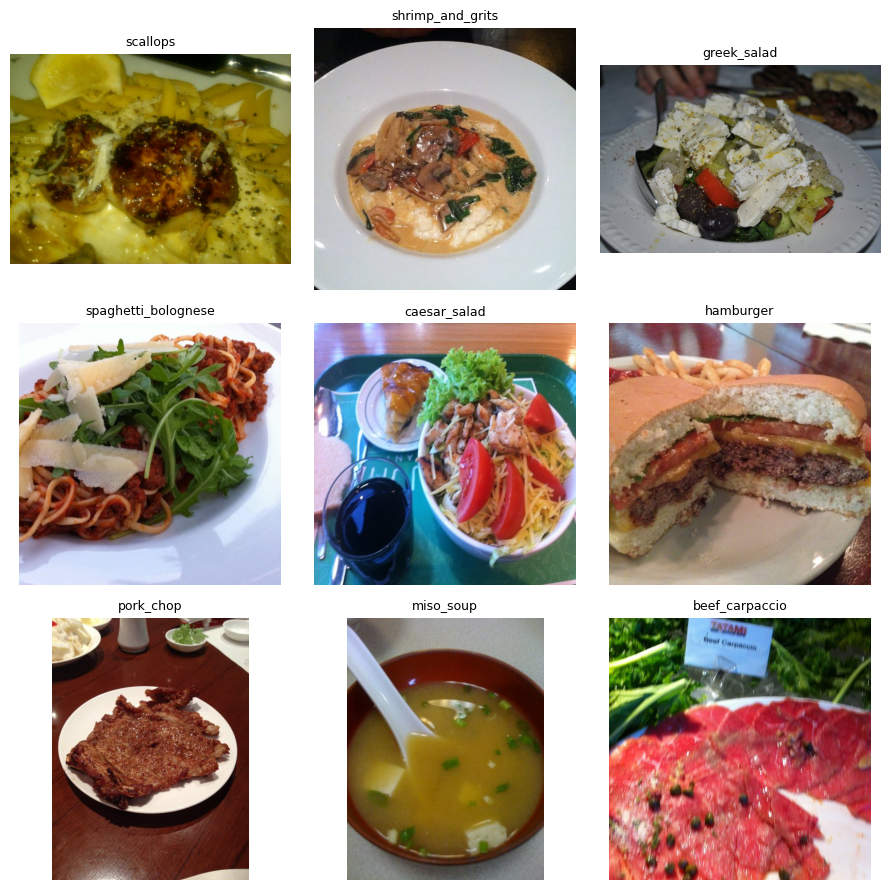

In [8]:
def show_random_food_images(ds_split, label_names, n=9, cols=3, seed=42):
    random.seed(seed)
    idxs = random.sample(range(len(ds_split)), n)
    rows = math.ceil(n/cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, idx in enumerate(idxs, 1):
        ex = ds_split[idx]
        plt.subplot(rows, cols, i)
        plt.imshow(ex["image"]); plt.axis("off")
        plt.title(label_names[ex["label"]], fontsize=9)
    plt.tight_layout(); plt.show()

show_random_food_images(train_ds, food_label_names, n=9, cols=3, seed=random_seed)

In [9]:
# Your code to expand on the EDA here; add as many cells as you wish



---

### Dataset Two (Text): HuffPost Dataset

#### **Load HuffPost (headline + summary + category)**

> Note: this loads a **Hugging Face `Dataset`**, not a NumPy array or Pandas DataFrame.
> Each record is a **dictionary** with fields such as `"headline"`, `"short_description"`, and `"category"`.
> You can access columns by name (e.g., `huff["headline"]`) and check dataset size with `len(huff)`.
> Treat it as a table of text fields — you’ll handle tokenization and vectorization later during preprocessing.



In [10]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


#### **Quick sanity checks (peek at a row)**

In [11]:
ex = huff_all[0]
print("One example:")
print("  category          :", ex.get("category"))
print("  headline          :", (ex.get("headline") or "")[:120])
print("  short_description :", (ex.get("short_description") or "")[:120])
print("  date              :", ex.get("date"))

One example:
  category          : CRIME
  headline          : There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
  short_description : She left her husband. He killed their children. Just another day in America.
  date              : 2018-05-26 00:00:00


#### **Build model input text: `headline [SEP] short_description`**

In [12]:
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

# Add a 'text' column (keep all other columns)
huff_all = huff_all.map(mk_text)
print("Columns after adding 'text':", huff_all.column_names)

Columns after adding 'text': ['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']


#### **Class-encode labels and list all categories**

In [13]:
# Convert 'category' (strings) to a ClassLabel (ints with vocabulary)
if not isinstance(huff_all.features["category"], ClassLabel):
    huff_all = huff_all.class_encode_column("category")

label_names = huff_all.features["category"].names
print(f"Classes: {len(label_names)}")
for i, name in enumerate(label_names):
    print(f"{i:2d}: {name}")

Classes: 41
 0: ARTS
 1: ARTS & CULTURE
 2: BLACK VOICES
 3: BUSINESS
 4: COLLEGE
 5: COMEDY
 6: CRIME
 7: CULTURE & ARTS
 8: DIVORCE
 9: EDUCATION
10: ENTERTAINMENT
11: ENVIRONMENT
12: FIFTY
13: FOOD & DRINK
14: GOOD NEWS
15: GREEN
16: HEALTHY LIVING
17: HOME & LIVING
18: IMPACT
19: LATINO VOICES
20: MEDIA
21: MONEY
22: PARENTING
23: PARENTS
24: POLITICS
25: QUEER VOICES
26: RELIGION
27: SCIENCE
28: SPORTS
29: STYLE
30: STYLE & BEAUTY
31: TASTE
32: TECH
33: THE WORLDPOST
34: TRAVEL
35: WEDDINGS
36: WEIRD NEWS
37: WELLNESS
38: WOMEN
39: WORLD NEWS
40: WORLDPOST


#### **EDA: counts per category (all classes) + bar chart**

Per-class totals (descending):


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: count, dty

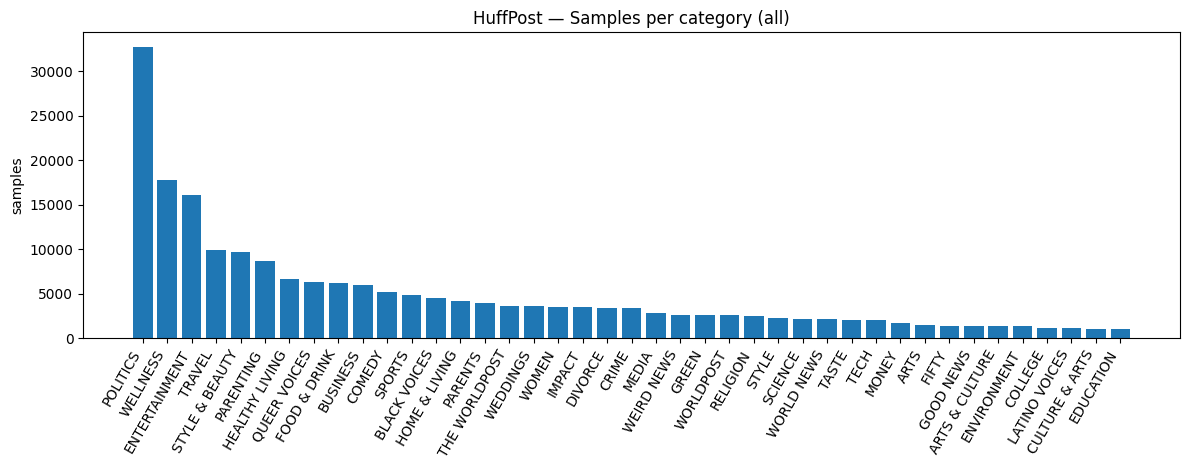

In [14]:
counts = pd.Series(huff_all["category"]).value_counts().sort_index()
counts.index = [label_names[i] for i in counts.index]
counts = counts.sort_values(ascending=False)

print("Per-class totals (descending):")
display(counts)

plt.figure(figsize=(12, 4.8))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=60, ha='right'); plt.ylabel("samples")
plt.title("HuffPost — Samples per category (all)")
plt.tight_layout(); plt.show()

#### **Create dataset and make 80/10/10 split (stratified by category)**

In [15]:
# 10% test, then ~10% of remaining for validation
tmp = huff_all.train_test_split(test_size=0.10, seed=random_seed, stratify_by_column="category")
train_val = tmp["train"].train_test_split(test_size=1/9, seed=random_seed, stratify_by_column="category")

huff = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

# Split sizes + per-class min/max (sanity check)
for split in ["train","val","test"]:
    vc = pd.Series(huff[split]["category"]).value_counts().sort_index()
    print(f"{split.upper():5s} | n={len(huff[split])} | classes={len(vc)} | min={vc.min()} max={vc.max()}")

TRAIN | n=160681 | classes=41 | min=804 max=26191
VAL   | n=20086 | classes=41 | min=100 max=3274
TEST  | n=20086 | classes=41 | min=100 max=3274


#### 8) **Print 10 random samples (full text, no truncation)**

In [16]:
def show_random_huff(ds_split, k=10, seed=random_seed):
    random.seed(seed)
    idxs = random.sample(range(len(ds_split)), k)
    for i in idxs:
        ex = ds_split[i]
        lbl = label_names[ex["category"]]
        print("="*120)
        print(f"[{i}] Category: {lbl}")
        if ex.get("headline"):
            print("Headline:", ex["headline"].replace("\n"," "))
        if ex.get("short_description"):
            print("Summary :", ex["short_description"].replace("\n"," "))
        print("Text    :", ex["text"].replace("\n"," "))

show_random_huff(huff["train"], k=10, seed=7)

[84890] Category: HEALTHY LIVING
Headline: When The Doctor Becomes The Patient: What I Learned From Having A Surgical Complication
Summary : "I’ve never seen this before” is never something you want to hear.
Text    : When The Doctor Becomes The Patient: What I Learned From Having A Surgical Complication [SEP] "I’ve never seen this before” is never something you want to hear.
[39544] Category: SPORTS
Headline: The 9 Best Videos Of People Losing It After Villanova’s Game-Winner
Summary : Total madness.
Text    : The 9 Best Videos Of People Losing It After Villanova’s Game-Winner [SEP] Total madness.
[103500] Category: COMEDY
Headline: 19 Comedians Confronting Hecklers (NSFW VIDEO)
Summary : No one heckles quite like hecklers at a comedy show. You wouldn't hear someone yell their opinions at a solo jazz performer
Text    : 19 Comedians Confronting Hecklers (NSFW VIDEO) [SEP] No one heckles quite like hecklers at a comedy show. You wouldn't hear someone yell their opinions at a solo jazz 

#### **(Optional) Save splits to disk (reload later without re-splitting)**

We provide this in case you want to save the dataset to your local disk. Saving Food-101 splits to disk is not recommended unless you have ample local storage (it's huge!). 

In [17]:
# huff.save_to_disk("huffpost_splits")        # save
# from datasets import load_from_disk
# huff = load_from_disk("huffpost_splits")  # reload when needed

In [18]:
# Your code to expand on the EDA here; add as many cells as you wish



---

## Problem 1 – Choose the Dataset (10 pts)

#### Objective
In this problem, you will explore the two provided datasets and select one to use for your final project.  
Your goal is to understand the structure, content, and challenges of the dataset through basic exploratory data analysis (EDA).  
By the end of this Milestone notebook, you should be able to explain what makes the dataset interesting, identify potential modeling challenges (e.g., imbalance, ambiguity, quality issues), and justify why it is a good choice for your classification project.


#### What to Do
1. **Load both datasets** and examine the outputs of the template code provided.  
   After this brief inspection, **choose one dataset for your project** and **delete the template code for the other.**  
   For your chosen dataset, continue with the remaining steps.

2. **Inspect** the dataset's basic properties:  
   - **Number of samples and classes:**  
     Determine how many total examples and distinct categories are present. Verify that the counts match expectations (e.g., 101 food classes or 41 news topics).  
   - **Example records or images:**  
     View several samples to understand the input format, diversity, and potential quality issues.  
     For images, note lighting or composition differences; for text, read a few headlines and summaries to see how expressive they are.  
   - **Distribution of labels (check for imbalance):**  
     Plot or tabulate label frequencies to see whether some classes dominate. Imbalanced datasets can bias model training and may require special handling.  
   - **Missing or inconsistent data:**  
     Look for empty fields, unreadable images, duplicate entries, or mislabeled samples. Handle or document any issues you find.  
   - **Overlapping or ambiguous class labels:**  
     Identify categories that may not be clearly distinct—e.g., “apple pie” vs. “cheesecake,” or “POLITICS” vs. “WORLD NEWS.”  
     Ambiguity in labels can increase confusion between classes and reduce model accuracy.

3. **Visualize key aspects:**  
   Extend the template code to complete the EDA for your chosen dataset:  
   - **Images:**  
     Create visual summaries to better understand the data (some are implemented in the template code).  
     - Verify that the dataset is balanced across classes.  
     - Display a small grid of random images to check variation in appearance, composition, and background.  
     - Compare image sizes to determine whether resizing or normalization will be needed.  
     - Examine lighting and color balance—many web-scraped photos vary widely in brightness, saturation, and white balance.  
   - **Text:**  
     Visualize class balance and linguistic properties (some implemented in the template code).  
     - Plot the number of samples per label to confirm class balance or imbalance.  
     - Compute basic text statistics such as average word count or vocabulary size.  
     - Examine examples for duplicates, near-duplicates, or entries that might fit multiple categories.  
     - *(Optional)* Generate a word-frequency plot or word cloud to highlight distinctive terms for a few classes.

4. **Answer the graded questions below.**


### Graded Questions for Problem One

1. **Dataset Summary:**  
   Describe your chosen dataset in 4-5 sentences (as if explaining to your *clueless boss* what you are working on).
   - State which dataset you are going to use.   
   - What kind of data does it contain (images or text)?  
   - How many samples and classes are there?  
   - What is the task you’ll perform (classification into what categories)?
   - What is the potential business use for this dataset?

1.2. **Your answer here:**



2. **Initial Observations:**  
   What stood out to you from your EDA?  
   - Did you notice any imbalanced or ambiguous classes?  
   - Any patterns, anomalies, or potential sources of bias?  
   - For images: note any variation in lighting, composition, or color.  
   - For text: mention redundancy, topic overlap, or very short examples.

**1.2. Your answer here:**



3. **Challenges & Implications:**  
   Based on your inspection, what challenges might affect model performance or training (e.g., imbalance, ambiguous labels, variable quality)?  

**1.3. Your answer here:**



4. **Preparation Ideas:**  
   What data-cleaning or preprocessing steps might help address these issues?  
   (You will not implement these yet—just describe what you might do later.)

1.4. **Your answer here:**



5. **Reflection:**  
   Why did you choose this dataset over the other one?  
   - What makes it more interesting, realistic, or relevant for you?  
   - What do you expect to learn from working with it?

1.5. **Your answer here:**



## Part 2 – Frame the Problem (10 pts)

### Objective
Define your classification problem clearly and describe how success will be measured.

### What to Do
1. **State the prediction task**  
   - Describe what your model will predict (the *label*).  
   - *Examples:*  
     - “Given a photo of food, predict which of 101 categories it belongs to.”  
     - “Given a news headline + summary, predict its topical category.”  

**2.1. Your answer here:**



2. **Define inputs and outputs**  
   - *Inputs:* what information the model receives (e.g., pixel data, tokenized text).  
   - *Outputs:* the categorical label the model will predict.  

**2.2. Your answer here:**



3. **Identify possible challenges**  
   - Imbalanced classes, noisy data, ambiguous labels, or overlapping features.  
   - *Images:* variation in lighting, color, composition, or size.  
   - *Text:* class imbalance, duplicate stories, short or ambiguous headlines.  

**2.3. Your answer here:**



4. **Propose how you will prepare or improve the data**  
   - *Images:* resizing, normalization, data augmentation (flips, rotations, color jitter).  
   - *Text:* tokenization, stop-word removal, class balancing, embedding creation (which embedding strategy and what size). 

**2.4. Your answer here:**



5. **Specify success metrics**  
   - Identify the metrics you plan to use to evaluate model performance—typically **accuracy** and/or **F1-score**, which are standard for classification tasks.  
   - Briefly explain **why** these metrics are appropriate for your dataset and goal. For instance, accuracy may suffice for well-balanced datasets, while F1-score better reflects performance when some classes are under-represented.  
   - If your dataset is **imbalanced**, consider computing **per-class metrics** (e.g., precision, recall, or F1 for each label) or **macro-averaged scores** to ensure that minority classes are evaluated fairly (we did not study all possible metrics, but have a conversation with your favorite generative AI tool about which metrics might be useful for your dataset). 
   - Clearly state how you will interpret success—for example, “Our goal is to achieve at least 80% overall accuracy without large per-class disparities.”

2.5. **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone. 

**AI Question: Your answer here:**

---

## Appendix: A quick guide to Hugging Face Datasets

#### 1) What are they?

* A **table-like** dataset: rows = examples, columns = named fields (e.g., `"image"`, `"label"`, `"headline"`).
* Backed by **Apache Arrow** → fast, memory-efficient, lazy transforms.
* Two core objects:

  * `Dataset` — one table of rows/columns.
  * `DatasetDict` — a dict of splits, e.g. `{"train": Dataset, "val": Dataset, "test": Dataset}`.


#### 2) Load and inspect

```python
from datasets import load_dataset

# Food-101 (images)
food = load_dataset("food101", split="train+validation")  # both splits at once
len(food), food.column_names, food.features
# -> (≈101000, ['image','label'], {'label': ClassLabel(num_classes=101, names=[...])})

# Access by name (not by numeric column index!)
row0 = food[0]
img0, y0 = row0["image"], row0["label"]     # PIL image, int id
label_names = food.features["label"].names
label_names[y0]
```

For text (HuffPost JSON mirror):

```python
url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff = load_dataset("json", data_files=url, split="train")
huff.column_names  # e.g. ['headline','short_description','category','authors','link','date']
```


#### 3) Common transforms

`Dataset`s are **immutable**: ops return a new dataset.

* **Map** (add/modify columns):

```python
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

huff = huff.map(mk_text)  # adds 'text' column
```

* **Class-encode** labels (strings → integers with a vocabulary):

```python
from datasets.features import ClassLabel
if not isinstance(huff.features["category"], ClassLabel):
    huff = huff.class_encode_column("category")  # now ints with .names
```

* **Filter / select / rename / drop**:

```python
small = huff.select(range(5000))  # first 5k rows
huff = huff.remove_columns(["authors","link","date"])
huff = huff.rename_column("category", "label")
```


#### 4) Splitting & shuffling

```python
# Stratified 80/10/10 on Food-101 by 'label'
from datasets import DatasetDict
label_col = "label"

tmp = food.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=42, stratify_by_column=label_col)
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

len(ds["train"]), len(ds["val"]), len(ds["test"])
```

* `train_test_split` is **random by default** (reproducible with `seed=`).
* You typically **don’t need to pre-shuffle** datasets if your training dataloader already shuffles each epoch.


#### 5) Working with images

Use `with_transform` to apply on-the-fly resizing/augmentation and return tensors:

```python
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch, math, random

IM_SIZE = 224
train_tfms = T.Compose([T.RandomResizedCrop(IM_SIZE), T.RandomHorizontalFlip(), T.ToTensor()])
eval_tfms  = T.Compose([T.Resize(256), T.CenterCrop(IM_SIZE), T.ToTensor()])

def add_pixel_values(ex, tfms):  # ex['image'] -> ex['pixel_values']
    ex = dict(ex); ex["pixel_values"] = tfms(ex["image"]); return ex

train_t = ds["train"].with_transform(lambda ex: add_pixel_values(ex, train_tfms))
val_t   = ds["val"].with_transform(lambda ex: add_pixel_values(ex, eval_tfms))

def collate(batch):
    return {"pixel_values": torch.stack([b["pixel_values"] for b in batch]),
            "labels": torch.tensor([b["label"] for b in batch])}

train_loader = DataLoader(train_t, batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_t,   batch_size=64, shuffle=False, collate_fn=collate)
```

### 6) Working with Text

You can preprocess and tokenize text datasets using either a **transformer tokenizer** or a **linguistic pipeline like spaCy**, depending on your model type and goals.


#### Option A: Transformer Tokenizer (for fine-tuning models like BERT or DistilBERT)

Use a pretrained tokenizer with the Hugging Face `map` method to efficiently process your dataset in batches:

```python
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = huff.map(
    tokenize,
    batched=True,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

This produces token IDs, attention masks, and other fields expected by transformer models.
Use this approach if your project involves fine-tuning pretrained language models.


#### Option B: spaCy Tokenization and Cleaning (for classical ML or custom preprocessing)

If you are **not using transformers**, or if you want to explore feature engineering (e.g., TF-IDF, word frequency, or embedding averages), you can preprocess text with **spaCy** instead.

```python
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS

def spacy_clean(batch):
    docs = list(nlp.pipe(batch["text"], batch_size=1000))
    cleaned = []
    for doc in docs:
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
    return {"text_clean": cleaned, "len_tokens": [len(c.split()) for c in cleaned]}

huff = huff.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

The resulting column `text_clean` can be used with:

* `TfidfVectorizer` (Scikit-learn)
* `TextVectorization` (Keras)
* or any other custom embedding method.

> 💡 **Tip:** spaCy is ideal for lightweight NLP pipelines or for models that rely on explicit preprocessing (lemmatization, stopword removal). Transformer tokenizers, by contrast, expect *raw text* and handle subword tokenization internally.



#### 7) Slicing, concatenating, saving

```python
# Slicing
head_1000 = food.select(range(1000))
tail_10pct = food.select(range(int(0.9*len(food)), len(food)))

# Concatenate splits/datasets
from datasets import concatenate_datasets
all_train = concatenate_datasets([ds["train"], ds["val"]])

# Save / reload
ds.save_to_disk("food101_splits")
from datasets import load_from_disk
ds2 = load_from_disk("food101_splits")
```


#### 8) Quick “gotchas”

* **Columns by name** (strings), not numeric indices.
* Avoid converting huge columns to `list(...)` unless necessary; prefer vectorized ops with `map`, `filter`, `select`.
* `PYTHONHASHSEED` must be set **before** the Python process starts to matter; use explicit `seed=` arguments for reproducibility.
* Datasets print **previews** (e.g., `Column([6, 6, 6, ...])` is just the first few values).


#### 9) A minimal checklist to follow

1. `load_dataset(...)` → confirm `column_names`, `features`.
2. Build any needed columns (`"text"`), and **class-encode** labels if strings.
3. Make a **stratified 80/10/10** split (`train_test_split` ×2).
4. Do **EDA**: class counts, sample printouts or image grids.
5. For training:

   * **images** → `with_transform` + DataLoader
   * **text** → tokenizer via `.map(...)` + trainer/model pipeline
6. Save your `DatasetDict` with `save_to_disk(...)` (optional for text but handy, **don't** use it for big image datasets).

